<a href="https://colab.research.google.com/github/arampacha/fastai_nbs/blob/main/sentence_encodings_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai

     |████████████████████████████████| 194kB 8.4MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 


In [2]:
from fastai.text.all import *

In [3]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler

from itertools import combinations

In [4]:
plt.set_cmap('Set1');

<Figure size 432x288 with 0 Axes>

## Data

In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2020-10-25 22:27:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  25.2MB/s    in 1.1s    

2020-10-25 22:27:23 (25.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [6]:
path = Path('./data')
if not path.exists(): 
    path.mkdir()

In [7]:
import zipfile
with zipfile.ZipFile('/content/NewsAggregatorDataset.zip') as f:
    f.extractall(path)

In [8]:
df = pd.read_csv('./data/newsCorpora.csv', sep='\t', names=['id','title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp'])
df = df[['title', 'category']]
catmap = {
    'e':'Entertainment',
    'b':'Business',
    't':'Science',
    'm':'Health'
}

def update_cat(x):
    return catmap[x]

df['category'] = df['category'].apply(lambda x: update_cat(x))

In [9]:
df.head(2)

,title,category
0,"Fed official says weak data caused by weather, should not slow taper",Business
1,Fed's Charles Plosser sees high bar for change in pace of tapering,Business


In [10]:
length = df.title.str.split()
length = length.map(len)
length.describe()

count    422419.000000
mean          9.257413
std           6.431410
min           1.000000
25%           7.000000
50%           9.000000
75%          11.000000
max        2045.000000
Name: title, dtype: float64

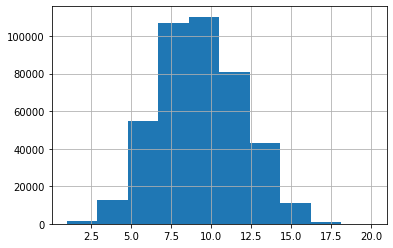

In [11]:
length[length <=20].hist(bins=10);

In [12]:
df = df[length <= 20]
df['title'] = df.title.str.lower()

Using subset of data to speed up things.

In [13]:
titles = df.sample(100000).reset_index(drop=True)

There might be some rare words which can be in original model vocab, so `min_freq=1`. Not sure it's reasonable, though

In [14]:
dblock = DataBlock(blocks=(TextBlock.from_df('title', min_freq=1, n_workers=4, res_col_name='title'), 
                           CategoryBlock),
                   get_x = ColReader('title'), 
                   get_y = ColReader('category'),
                   splitter = RandomSplitter(0.5))

In [15]:
%%time
dls = dblock.dataloaders(titles, bs=128, n_workers=4)

CPU times: user 1min 38s, sys: 2.08 s, total: 1min 40s
Wall time: 2min 4s


In [16]:
dls.show_batch(max_n=5)

,text,category
0,"xxbos it 's a bird ! it 's a plane ! no , it 's jada pinkett smith on the cover of net - a - porter 's …",Entertainment
1,"xxbos weekend movies & tv : ' rio 2 , ' ' draft day , ' ' mad men , ' & more ( video ) xxpad xxpad xxpad",Entertainment
2,xxbos ' i 'll f xxrep 3 * you up ' shia labeouf threatens cops on arrest & ' given mask to stop spitting ' xxpad xxpad xxpad xxpad,Entertainment
3,xxbos ' x - men ' atop memorial day holiday opener bests ' godzilla ' with $ xxrep 3 1 m box office … xxpad xxpad xxpad xxpad xxpad,Entertainment
4,"xxbos 10 things you need to know this morning ( dia , spy , xxrep 3 q , mcd , yum , t … xxpad xxpad xxpad xxpad xxpad",Business


In [17]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)#.to_fp16()

## Sentence embeddings without finetuning

Following functions are factored parts of `masked_concat_pool` function used in standard classifier head in ULMFiT

In [18]:
def masked_max_pool(output, mask, bptt):
    return output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]

def last_hdn_pool(output, mask, bptt):
    last_lens = mask[:,-bptt:].long().sum(dim=1)
    return output[torch.arange(0, output.size(0)),-last_lens-1]

def masked_avg_pool(output, mask, bptt):
    lens = output.shape[1] - mask.long().sum(dim=1)
    avg_pool = output.masked_fill(mask[:, :, None], 0).sum(dim=1)
    avg_pool.div_(lens.type(avg_pool.dtype)[:,None])
    return avg_pool

In [19]:
_pooler = {
    'concat': masked_concat_pool,
    'max': masked_max_pool,
    'last': last_hdn_pool,
    'avg': masked_avg_pool,
}

In [20]:
def get_sentence_encodings(learn, dl=None, method='max'):
    if dl is None:
        dl = learn.dls.valid
    learn.model.to(dl.device)
    learn.model.eval()
    sentence_encoder = learn.model[0]
    sentence_encoder.reset()
    bptt = getattr(sentence_encoder, 'bptt')
    encodings = []
    y = []
    pool = _pooler[method]
    pbar = progress_bar(dl)
    for b in pbar:
        xb = b[0]
        with torch.no_grad():
            enc, mask = sentence_encoder(xb)
        encodings.append(pool(enc, mask, bptt))
        if len(b)==2: y.append(b[1])
    if y:
        return torch.cat(encodings), torch.cat(y)
    else:
        return torch.cat(encodings), None

In [21]:
encodings, y = get_sentence_encodings(learn)

In [22]:
def to_np(t):
    return t.detach().cpu().numpy()

In [23]:
sentence_encs = to_np(encodings)
y_np = to_np(y)
sentence_encs.shape

(50000, 400)

Constructing test dataloader. Here I use first 1000 elements from original dataframe, but it could be any data structured in the same way.

In [24]:
test_dl = dls.test_dl(df[:1000])
test_dl.show_batch(max_n=5)

,text
0,xxbos watch us play titanfall for xbox one ( poorly ) right here ! ( update : and it 's over ! )
1,xxbos herbalife ltd . ( hlf ) news : herbalife : 4 ' need to know ' facts for this coming … xxpad
2,xxbos chiquita ( cqb ) and fyffes ( fy xxrep 3 f ) merge to become world 's largest banana … xxpad xxpad
3,xxbos forex market : eur / usd retreats from 2 - 1 / 2-year highs as stronger euro seen … xxpad xxpad xxpad
4,xxbos pollen and birds xxunk ? check and check . here are 5 ways to tell that spring 's … xxpad xxpad xxpad


In [25]:
test_encs, _ = get_sentence_encodings(learn, test_dl)

In [26]:
test_encs.shape

torch.Size([1000, 400])

In [27]:
test_dl = dls.test_dl(['This is random sentence'])

In [28]:
test_dl.show_batch()

,text
0,xxbos xxmaj this is random sentence


In [29]:
test_encs, _ = get_sentence_encodings(learn, test_dl)
test_encs.shape

torch.Size([1, 400])

### Visualization

In [ ]:
use_sample = False
if use_sample:
    idx = np.random.permutation(range_of(sentence_encs))[:1e4]
    encs = sentence_encs[idx]
    ys = y_np[idx]
else:
    encs = sentence_encs
    ys = y_np

#### PCA

In [ ]:
pca = PCA(3)
sent_3d = pca.fit_transform(encs)
pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)

(array([0.07519753, 0.03708632, 0.02682363], dtype=float32),
 0.1391074825078249)

Lot's of info lost, first 3 components contain only around 14% of variance in the data

In [ ]:
sample = sent_3d[:100]
y_sample = y_np[:100]

In [ ]:
def plot_2d(x, y):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, (j, k) in enumerate(combinations(range(3), 2)):
        ax = axs[i]
        ax.scatter(x[:,j], x[:,k], c=y, cmap='Set1')
        ax.set_xlabel(f'C {j}')
        ax.set_ylabel(f'C {k}')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

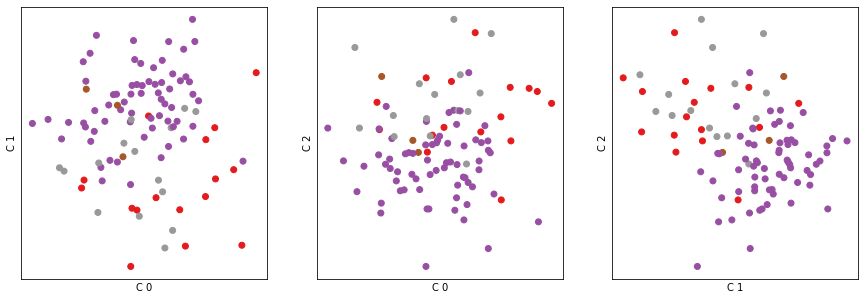

In [ ]:
plot_2d(sample, y_sample)

In [ ]:
def plot_3d(x, y):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    markers = ['o', '*', '^', 's']
    for i in range(4):
        idx = y == i
        ax.scatter(x[idx,0], x[idx,1], x[idx,2], marker=markers[i], s=50, alpha=1)
    ax.set_xlabel(f'C 0'); ax.set_ylabel(f'C 1'); ax.set_zlabel(f'C 2');
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
    
    plt.show()

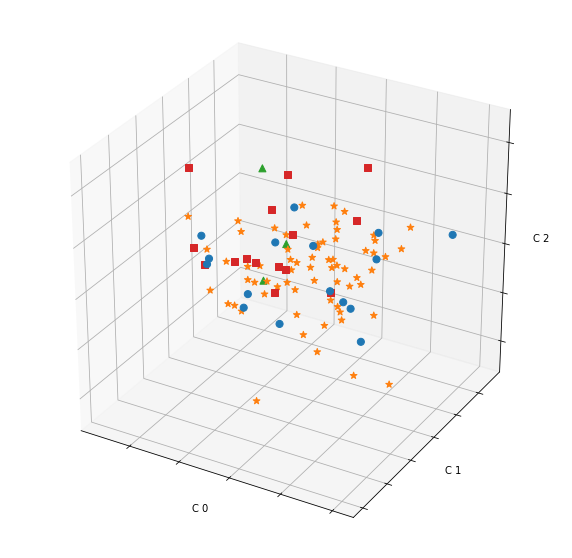

In [ ]:
plot_3d(sample, y_sample)

### t-SNE

Let's try fancier dimentionality reduction technique. [t-SNE](https://lvdmaaten.github.io/tsne/) is specifically designed for visualization of high dimensional data in 2d.

In [ ]:
pca50 = PCA(50)
encs_trunc = pca50.fit_transform(encs)
sum(pca50.explained_variance_ratio_)

0.5072251642122865

Note that t-SNE might take a lot of time

In [ ]:
tsne = TSNE(n_jobs=-1)

In [ ]:
%%time
encs_2d = tsne.fit_transform(encs_trunc)

CPU times: user 22min 55s, sys: 651 ms, total: 22min 56s
Wall time: 18min 50s


In [ ]:
sample = encs_2d[:100]
y_sample = y_np[:100]

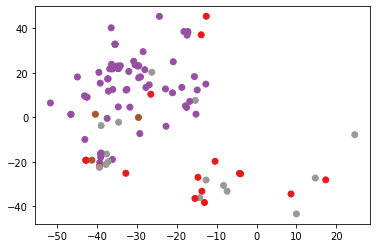

In [ ]:
plt.scatter(sample[:,0], sample[:,1], c=y_sample);

Also it needs some tuning to work well

In [ ]:
%%time
tsne = TSNE(n_jobs=-1, perplexity=10)
encs_2d = tsne.fit_transform(encs_trunc)

CPU times: user 17min 50s, sys: 677 ms, total: 17min 51s
Wall time: 14min 2s


In [ ]:
sample = encs_2d[:100]
y_sample = y_np[:100]

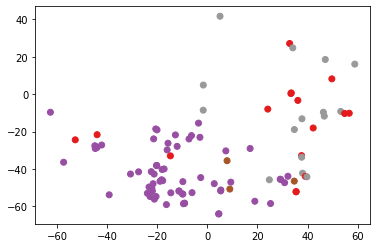

In [ ]:
plt.scatter(sample[:,0], sample[:,1], c=y_sample);